# Importing Necessary Libraries

In [13]:
import sqlite3

import numpy as np
import pandas as pd
pd.options.display.max_columns=None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Reading the dataset

In [18]:
connection = sqlite3.connect('data.db')

In [19]:
df = pd.read_sql(sql="SELECT * FROM airline_reviews", con=connection, parse_dates=['review_date'])

# About ML Model
- We shall drop the `customer_review` and `review_clean` column and train a ML model to predict `recommended` status based on the remaining features.
- We shall also drop `review_date` and `author` columns since these won't be important in model building.
- Sentiment analysis of the `customer_review` column shall be done in another notebook.
- Final recommendation of the overall project shall be `recommended` column based on:
    - `recommended` status prediction using ML model.
    - Sentiment analysis of `customer_review` column.

In [20]:
# Dropping 'customer_review' and 'recommended' columns.
df.drop(columns=['customer_review', 'review_clean', 'review_date', 'author'], inplace=True)

In [21]:
df.head()

airline  traveller_type          cabin type_of_flight frequency  \
0  Turkish Airlines        Business  Economy Class       Indirect    Rarely   
1  Turkish Airlines  Family Leisure  Economy Class         Direct    Rarely   
2  Turkish Airlines        Business  Economy Class       Indirect    Rarely   
3  Turkish Airlines    Solo Leisure  Economy Class         Direct    Rarely   
4  Turkish Airlines    Solo Leisure  Economy Class       Indirect    Rarely   

   seat_comfort  cabin_service  food_bev  entertainment  ground_service  \
0           4.0            5.0       4.0            4.0             2.0   
1           4.0            1.0       1.0            1.0             1.0   
2           1.0            4.0       1.0            3.0             1.0   
3           4.0            5.0       5.0            5.0             5.0   
4           1.0            1.0       1.0            1.0             1.0   

   value_for_money  overall recommended  
0              4.0      7.0         yes  
1              1.0      2.0          no  
2              2.0      3.0          no  
3              5.0     10.0         yes  
4              1.0      1.0          no

In [6]:
df.shape

(22826, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22826 entries, 0 to 22825
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          22826 non-null  object 
 1   traveller_type   22826 non-null  object 
 2   cabin            22826 non-null  object 
 3   type_of_flight   22826 non-null  object 
 4   frequency        22826 non-null  object 
 5   seat_comfort     22826 non-null  float64
 6   cabin_service    22826 non-null  float64
 7   food_bev         22826 non-null  float64
 8   entertainment    22826 non-null  float64
 9   ground_service   22826 non-null  float64
 10  value_for_money  22826 non-null  float64
 11  overall          22826 non-null  float64
 12  recommended      22826 non-null  object 
dtypes: float64(7), object(6)
memory usage: 2.3+ MB


# Checking if the dataset is balanced or imbalanced

In [8]:
df['recommended'].value_counts(1)

no     0.515202
yes    0.484798
Name: recommended, dtype: float64

#### Observations:
- Proportion of 'no' and 'yes' is very close to 50:50.
- We can safely say that our data is balanced and we can use `accuracy` to evaluate our model

# Splitting Dataset into features and target

In [9]:
X = df.drop(columns='recommended')
y = df['recommended']

## Train_test_split 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print(f"shape of X_train = {X_train.shape}")
print(f"shape of X_test = {X_test.shape}")
print(f"shape of y_train = {y_train.shape}")
print(f"shape of y_test = {y_test.shape}")

shape of X_train = (18260, 12)
shape of X_test = (4566, 12)
shape of y_train = (18260,)
shape of y_test = (4566,)


In [11]:
X_train.head()

airline  traveller_type           cabin type_of_flight  \
1104       Qatar Airways    Solo Leisure  Business Class         Direct   
21051  Frontier Airlines  Family Leisure   Economy Class         Direct   
4020   American Airlines        Business   Economy Class         Direct   
9664     British Airways  Couple Leisure  Business Class         Direct   
3761               other        Business   Economy Class         Direct   

          frequency  seat_comfort  cabin_service  food_bev  entertainment  \
1104         Rarely           3.0            5.0       5.0            3.0   
21051        Rarely           1.0            4.0       1.0            1.0   
4020         Rarely           1.0            2.0       1.0            1.0   
9664   Occasionally           4.0            3.0       1.0            4.0   
3761         Rarely           4.0            4.0       4.0            5.0   

       ground_service  value_for_money  overall  
1104              1.0              3.0      4.0  
21051             4.0              4.0      8.0  
4020              1.0              1.0      2.0  
9664              4.0              2.0      7.0  
3761              4.0              3.0      8.0

## Preprocessing Data
- Ordinal Encoding shall be performed on `class`, `type_of_flight` and `frequency` columns.
- One Hot Encoding shall be performed on `airline` and `traveller_type` columns.
- Min Max Scaling shall be performed on all the columns to scale entire data between 0 and 1.

### Ordinal Encoding 'class', 'type_of_flight' and 'frequency' columns

In [11]:
ord_1 = OrdinalEncoder(categories=[["Economy Class", "Premium Economy", "Business Class", "First Class"], ["Direct", "Indirect"], ["Rarely", "Occasionally", "Often"]])

X_train[['cabin', 'type_of_flight', 'frequency']] = ord_1.fit_transform(X_train[['cabin', 'type_of_flight', 'frequency']])
X_test[['cabin', 'type_of_flight', 'frequency']] = ord_1.transform(X_test[['cabin', 'type_of_flight', 'frequency']])

### One Hot Encoding 'airline' and 'traveller_type' columns

In [12]:
ohe_cols = ['airline', 'traveller_type']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

for col in ohe_cols:
    X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[[col]]), index = X_train.index, columns = sorted(X_train[col].unique()))
    X_test_ohe = pd.DataFrame(ohe.transform(X_test[[col]]), index = X_test.index, columns = sorted(X_test[col].unique()))
    X_train = pd.concat([X_train, X_train_ohe], axis = 1)
    X_test = pd.concat([X_test, X_test_ohe], axis = 1)

In [13]:
# Dropping 'airline' and 'traveller_type' columns
X_train.drop(columns=ohe_cols, inplace=True)
X_test.drop(columns=ohe_cols, inplace=True)

### Scaling the datasets using MinMaxScaler

In [14]:
mms = MinMaxScaler()

X_train_scaled = pd.DataFrame(mms.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(mms.transform(X_test), columns = X_test.columns)

### Encoding output column to integers (yes=1, no=0)


In [15]:
y_train.replace({'yes': 1, 'no': 0}, inplace=True)
y_test.replace({'yes': 1, 'no': 0}, inplace=True)

# Fitting Machine Learning Models

In [16]:
result_df = pd.DataFrame(columns = ["Model", "Accuracy_train", "Accuracy_test", "Recall", "Precision"])

In [17]:
# Defining a function to fit various models and save important parameters in a dataframe

def fit_models(X_train, X_test, y_train, y_test, model, model_name):
    
    temp_result = pd.DataFrame(columns=['Model', 'Accuracy_train', 'Accuracy_test', 'Recall', 'Precision'])
    
    print(f"Fitting {model_name} model... ")
    print("--------------------------------------------------")
    
    # Fitting model and taking predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculating metrics
    print(f"Accuracy on Train Data: {model.score(X_train, y_train)}")
    print(f"Accuracy on Test Data: {model.score(X_test, y_test)}")
    print(f"F1-score: {f1_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)} \n")
    
    # Displaying Confusion matrix
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name} Model")
    plt.show()
    
    # Displaying Classification Report
    print(f"Classification Report for {model_name} Model")
    print("--------------------------------------------------")
    print(classification_report(y_test, y_pred))
    
    # Saving metrics in a dataframe
    temp_result.loc[0] = [model_name, model.score(X_train, y_train), model.score(X_test, y_test), recall_score(y_test, y_pred), precision_score(y_test, y_pred)]
    
    return temp_result

### 1. Logistic Regression

Fitting Logistic Regression model... 
--------------------------------------------------
Accuracy on Train Data: 0.9588718510405257
Accuracy on Test Data: 0.9579500657030223
F1-score: 0.9565020389669233
Recall: 0.9534778681120144
Precision: 0.9595454545454546 



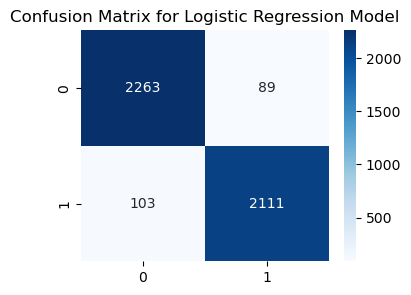

Classification Report for Logistic Regression Model
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2352
           1       0.96      0.95      0.96      2214

    accuracy                           0.96      4566
   macro avg       0.96      0.96      0.96      4566
weighted avg       0.96      0.96      0.96      4566



In [18]:
model_1 = LogisticRegression(max_iter= 1000, random_state=42)

output_1 = fit_models(X_train_scaled, X_test_scaled, y_train, y_test, model_1, "Logistic Regression")

### 2. Decision Tree Classifier

Fitting Decision Tree Classifier model... 
--------------------------------------------------
Accuracy on Train Data: 0.9996166484118292
Accuracy on Test Data: 0.9384581690757775
F1-score: 0.9363533408833521
Recall: 0.9336043360433605
Precision: 0.939118582462517 



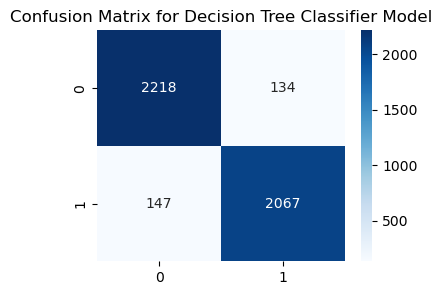

Classification Report for Decision Tree Classifier Model
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2352
           1       0.94      0.93      0.94      2214

    accuracy                           0.94      4566
   macro avg       0.94      0.94      0.94      4566
weighted avg       0.94      0.94      0.94      4566



In [19]:
model_2 = DecisionTreeClassifier(random_state=42)

output_2 = fit_models(X_train, X_test, y_train, y_test, model_2, "Decision Tree Classifier")

### 3. Random Forest Classifier

Fitting Random Forest Classifier model... 
--------------------------------------------------
Accuracy on Train Data: 0.9996166484118292
Accuracy on Test Data: 0.9561979851073149
F1-score: 0.9545454545454546
Recall: 0.948509485094851
Precision: 0.9606587374199451 



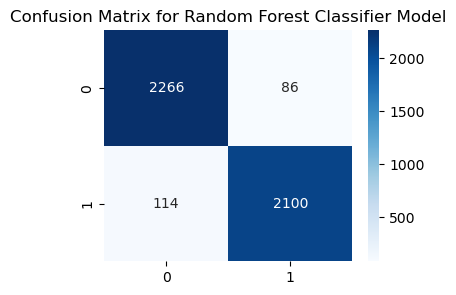

Classification Report for Random Forest Classifier Model
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2352
           1       0.96      0.95      0.95      2214

    accuracy                           0.96      4566
   macro avg       0.96      0.96      0.96      4566
weighted avg       0.96      0.96      0.96      4566



In [20]:
model_3 = RandomForestClassifier(random_state=42)

output_3 = fit_models(X_train, X_test, y_train, y_test, model_3, "Random Forest Classifier")

### 4. Support Vector Classifier

Fitting Support Vector Classifier model... 
--------------------------------------------------
Accuracy on Train Data: 0.9644578313253012
Accuracy on Test Data: 0.9568550153307052
F1-score: 0.9553591661001587
Recall: 0.952122854561879
Precision: 0.9586175534333788 



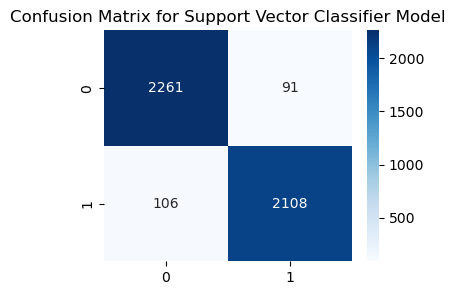

Classification Report for Support Vector Classifier Model
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2352
           1       0.96      0.95      0.96      2214

    accuracy                           0.96      4566
   macro avg       0.96      0.96      0.96      4566
weighted avg       0.96      0.96      0.96      4566



In [21]:
model_4 = SVC(random_state=42)
output_4 = fit_models(X_train_scaled, X_test_scaled, y_train, y_test, model_4, "Support Vector Classifier")

### 5. Naive Bayes Classifier

Fitting Gaussian Naive Bayes model... 
--------------------------------------------------
Accuracy on Train Data: 0.8757940854326397
Accuracy on Test Data: 0.8745072273324573
F1-score: 0.8720696584058941
Recall: 0.8821138211382114
Precision: 0.8622516556291391 



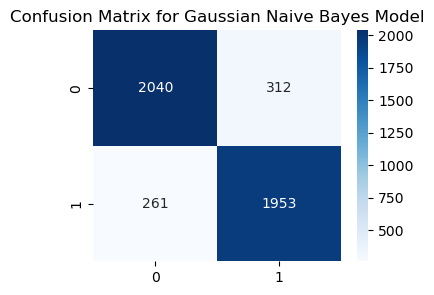

Classification Report for Gaussian Naive Bayes Model
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2352
           1       0.86      0.88      0.87      2214

    accuracy                           0.87      4566
   macro avg       0.87      0.87      0.87      4566
weighted avg       0.87      0.87      0.87      4566



In [22]:
model_5 = GaussianNB()
output_5 = fit_models(X_train, X_test, y_train, y_test, model_5, "Gaussian Naive Bayes")

## Showcasing Results of all base models

In [23]:
result_df = pd.concat([result_df, output_1, output_2, output_3, output_4, output_5], axis=0).reset_index(drop=True)
result_df

Model  Accuracy_train  Accuracy_test    Recall  \
0        Logistic Regression        0.958872       0.957950  0.953478   
1   Decision Tree Classifier        0.999617       0.938458  0.933604   
2   Random Forest Classifier        0.999617       0.956198  0.948509   
3  Support Vector Classifier        0.964458       0.956855  0.952123   
4       Gaussian Naive Bayes        0.875794       0.874507  0.882114   

   Precision  
0   0.959545  
1   0.939119  
2   0.960659  
3   0.958618  
4   0.862252

## Hyper Parameter Tuning
- We shall perform hyperparameter tuning for the 3 best performing base models:
    - Logistic Regression
    - Random Forest Classifier
    - Support Vector Classifier
    
- We shall use "Optuna" to find the best parameters for each model.

In [24]:
import optuna
from sklearn.model_selection import cross_val_score

### 1. Logistic Regression

In [25]:
def objective_lr(trial):
    solver = trial.suggest_categorical("solver", ['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    
    model = LogisticRegression(solver=solver, 
                               max_iter=max_iter, 
                               random_state=42)
    
    accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    
    return accuracy

In [26]:
# study_lr = optuna.create_study(direction="maximize")

In [27]:
# study_lr.optimize(objective_lr, n_trials=50)

In [28]:
# study_lr.best_params

In [29]:
# # Visualizing optimization history
# optuna.visualization.plot_optimization_history(study_lr)

Fitting Logistic Regression - Tuned model... 
--------------------------------------------------
Accuracy on Train Data: 0.9589266155531215
Accuracy on Test Data: 0.9579500657030223
F1-score: 0.9565020389669233
Recall: 0.9534778681120144
Precision: 0.9595454545454546 



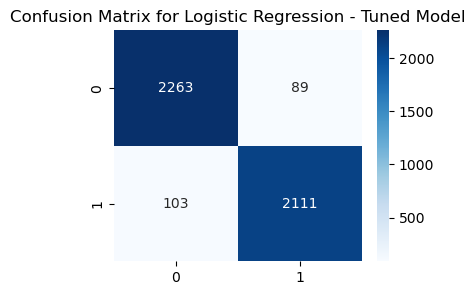

Classification Report for Logistic Regression - Tuned Model
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2352
           1       0.96      0.95      0.96      2214

    accuracy                           0.96      4566
   macro avg       0.96      0.96      0.96      4566
weighted avg       0.96      0.96      0.96      4566



In [30]:
# Fitting best Logistic regression model tuned using Optuna
model_lr_opt = LogisticRegression(max_iter=524, solver='liblinear', random_state=42)

output_lr_opt = fit_models(X_train_scaled, X_test_scaled, y_train, y_test, model_lr_opt, "Logistic Regression - Tuned")

### 2. Random Forest Classifier

In [31]:
def objective(trial):
    n_estimators= trial.suggest_int('n_estimators', 100, 1000)
    max_depth= trial.suggest_int('max_depth', 5, 50)
    min_samples_split= trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf= trial.suggest_int('min_samples_leaf', 1, 32)
    criterion= trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    model = RandomForestClassifier(n_estimators=n_estimators, 
                                   max_depth=max_depth, 
                                   min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf, 
                                   criterion=criterion, 
                                   random_state=42)
    
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    
    return accuracy

In [32]:
# study = optuna.create_study(direction='maximize') 

In [33]:
# study.optimize(objective, n_trials=200)

In [34]:
# # Getting best parameters from optuna study
# study.best_params

In [35]:
# # Visualizing optimization history
# optuna.visualization.plot_optimization_history(study)

Fitting Random Forest Classifier - Tuned model... 
--------------------------------------------------
Accuracy on Train Data: 0.9965498357064622
Accuracy on Test Data: 0.9561979851073149
F1-score: 0.954524783992724
Recall: 0.9480578139114725
Precision: 0.9610805860805861 



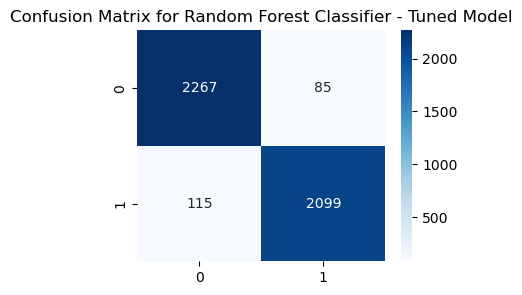

Classification Report for Random Forest Classifier - Tuned Model
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2352
           1       0.96      0.95      0.95      2214

    accuracy                           0.96      4566
   macro avg       0.96      0.96      0.96      4566
weighted avg       0.96      0.96      0.96      4566



In [36]:
# Fitting best Random Forest model tuned using optuna
model_rf_opt = RandomForestClassifier(n_estimators=559, 
                                      max_depth=21, 
                                      min_samples_split=2, 
                                      min_samples_leaf=1,
                                      criterion='entropy',
                                      random_state=42)

output_rf_opt = fit_models(X_train, X_test, y_train, y_test, model_rf_opt, "Random Forest Classifier - Tuned")

### 3. SVC

In [37]:
def objective_svc(trial):
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_float('gamma', 1e-4, 1e4, log=True)
    
    model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
    
    accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    
    return accuracy

In [38]:
# study_svc = optuna.create_study(direction='maximize')

In [39]:
# study_svc.optimize(objective_svc, n_trials=50)

In [40]:
# # Getting best parameters from optuna study
# study_svc.best_params

In [41]:
# # Visualizing optimization history
# optuna.visualization.plot_optimization_history(study_svc)

Fitting Support Vector Classifier - Tuned model... 
--------------------------------------------------
Accuracy on Train Data: 0.9965498357064622
Accuracy on Test Data: 0.9561979851073149
F1-score: 0.9545454545454546
Recall: 0.948509485094851
Precision: 0.9606587374199451 



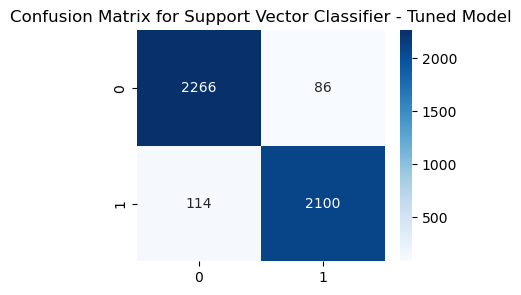

Classification Report for Support Vector Classifier - Tuned Model
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2352
           1       0.96      0.95      0.95      2214

    accuracy                           0.96      4566
   macro avg       0.96      0.96      0.96      4566
weighted avg       0.96      0.96      0.96      4566



In [42]:
# Fitting best SVC model tuned using optuna
model_SVC_opt = SVC(C= 9.20, kernel= 'linear', gamma= 0.0045)

output_SVC_opt = fit_models(X_train_scaled, X_test_scaled, y_train, y_test, model_rf_opt, "Support Vector Classifier - Tuned")

### Optimizing RandomForestClassifier model using GridSearchCV

In [43]:
# from sklearn.model_selection import GridSearchCV

# # Defining param_grid for GridSearchCV
# param_grid = {'n_estimators':[100, 200, 300, 400, 500],
#               'max_depth':[x for x in range(10,30,5)],
#               'min_samples_split':[x for x in range(2,30)],
#               'criterion':['gini', 'entropy'],
#               'max_features':['sqrt', 'log2']
#              }

# # Fitting GridSearchCV on RandomForestClassifier model
# model_rf = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=4, verbose=3)
# grid_search.fit(X_train, y_train)

In [44]:
# grid_search.best_params_

Fitting Random Forest Classifier - GSCV model... 
--------------------------------------------------
Accuracy on Train Data: 0.9647316538882804
Accuracy on Test Data: 0.9581690757774858
F1-score: 0.9566598593147265
Recall: 0.952122854561879
Precision: 0.9612403100775194 



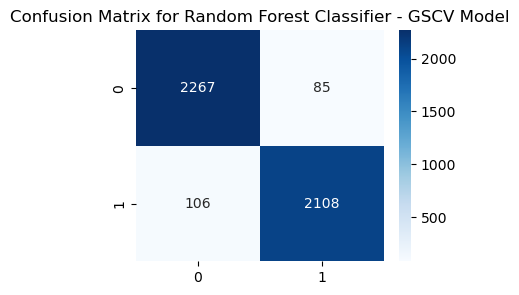

Classification Report for Random Forest Classifier - GSCV Model
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2352
           1       0.96      0.95      0.96      2214

    accuracy                           0.96      4566
   macro avg       0.96      0.96      0.96      4566
weighted avg       0.96      0.96      0.96      4566



In [45]:
# Fitting RandomForestClassifier model with best parameters obtained from GridSearchCV
model_rf_gs = RandomForestClassifier(n_estimators=359, criterion='gini', max_depth=16, max_features='log2', min_samples_split=25, random_state=42)

output_rf_gs = fit_models(X_train, X_test, y_train, y_test, model_rf_gs, "Random Forest Classifier - GSCV")

# Selecting Best model based on accuracy

In [46]:
# Appending tuned models to result dataframe
result_df = pd.concat([result_df, output_lr_opt, output_rf_opt, output_SVC_opt, output_rf_gs], axis=0).reset_index(drop=True)

In [47]:
result_df

Model  Accuracy_train  Accuracy_test    Recall  \
0                Logistic Regression        0.958872       0.957950  0.953478   
1           Decision Tree Classifier        0.999617       0.938458  0.933604   
2           Random Forest Classifier        0.999617       0.956198  0.948509   
3          Support Vector Classifier        0.964458       0.956855  0.952123   
4               Gaussian Naive Bayes        0.875794       0.874507  0.882114   
5        Logistic Regression - Tuned        0.958927       0.957950  0.953478   
6   Random Forest Classifier - Tuned        0.996550       0.956198  0.948058   
7  Support Vector Classifier - Tuned        0.996550       0.956198  0.948509   
8    Random Forest Classifier - GSCV        0.964732       0.958169  0.952123   

   Precision  
0   0.959545  
1   0.939119  
2   0.960659  
3   0.958618  
4   0.862252  
5   0.959545  
6   0.961081  
7   0.960659  
8   0.961240

In [ ]:
# Selecting Best model based on best test accuracy from the above table
final_model = RandomForestClassifier(n_estimators=359, 
                                     criterion='gini', 
                                     max_depth=16, 
                                     max_features='log2', 
                                     min_samples_split=25, 
                                     random_state=42)